#Лабораторная работа по курсу

In [1]:
# заранее импортируем основные модули
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#1. Загружаем данные

In [2]:
# скачиваем данные
!wget 'https://archive.ics.uci.edu/static/public/40/flags.zip'

--2024-11-29 13:10:40--  https://archive.ics.uci.edu/static/public/40/flags.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘flags.zip’

flags.zip               [ <=>                ]   5.72K  --.-KB/s    in 0s      

2024-11-29 13:10:40 (61.3 MB/s) - ‘flags.zip’ saved [5862]



In [3]:
import zipfile

# Путь к zip-архиву
archive_path = '/content/flags.zip'

# Распаковываем zip-архив
with zipfile.ZipFile(archive_path, 'r') as zip_ref:
    zip_ref.extractall()

In [4]:
cols = ['name','landmass','zone','area','population','language','religion','bars','stripes',
       'colours','red','green','blue','gold','white','black','orange','mainhue','circles',
       'crosses','saltires','quarters','sunstars','crescent','triangle','icon','animate',
       'text','topleft','botright']

# загружаю датасет
data = pd.read_csv('/content/flag.data', header=None, names=cols)
data.head()

,name,landmass,zone,area,population,language,religion,bars,stripes,colours,...,saltires,quarters,sunstars,crescent,triangle,icon,animate,text,topleft,botright
0,Afghanistan,5,1,648,16,10,2,0,3,5,...,0,0,1,0,0,1,0,0,black,green
1,Albania,3,1,29,3,6,6,0,0,3,...,0,0,1,0,0,0,1,0,red,red
2,Algeria,4,1,2388,20,8,2,2,0,3,...,0,0,1,1,0,0,0,0,green,white
3,American-Samoa,6,3,0,0,1,1,0,0,5,...,0,0,0,0,1,1,1,0,blue,red
4,Andorra,3,1,0,0,6,0,3,0,3,...,0,0,0,0,0,0,0,0,blue,red


#2. Анализ данных

Описание набора данных: Атрибутивная информация:

1. name: название соответствующей страны
2. landmass: 1=Северная Америка, 2=Южная Каролина.Америка, 3= Европа, 4= Африка, 4=Азия, 6= Океания
3. zone: географического квадранта, основанная на Гринвиче и экваторе, 1= Северо-запад, 2= ЮГО-восточная Азия, 3=Юго-Западная Азия, 4=Северо-Западная Азия
4. area: площадь в тысячах квадратных километров
5. population: население в миллионах
человек
6. language: язык 1=Английский, 2=Испанский, 3= Французский, 4= немецкий, 5= славянский, 6= Другие индоевропейские языки, 7= Китайский, 8= Арабский, 9= Японский/Турецкий/ финский/ мадьярский, 10= Другие
7. bars: Количество вертикальных полос на флаге
8. stripes: Количество горизонтальных полос
9. colours: Количество различных цветов на флаге
10. red: 0, если красный отсутствует, 1, если красный присутствует на флаге
11. green: такой же для зеленого
12. blue: такой же для синего
13. gold: такой же для золотого (также желтого)
14. white: такой же для белого
15. black: такой же для черного
16. orange: то же самое для оранжевого (также коричневого)
17. mainhue: основной цвет, преобладающий на флаге (тай-брейки определяются путем выбора самого верхнего оттенка, если это не удается, то самого центрального оттенка, а если это не удается, то самого левого оттенка)
18. circles: Количество кругов на флаге
19. crosses: Количество вертикальных
крестов
20. saltires: Количество диагональных крестов
21. quarters: Количество секций, разделенных на четверти
22. sunstars: Количество символов солнца или звезды
23. crescent: полумесяц 1, если присутствует символ полумесяца, иначе 0
24. triangle: треугольник 1, если присутствуют какие-либо треугольники, 0 в противном
случае
25. icon: значок 1, если присутствует неодушевленное изображение (например, лодка), в противном случае 0
26. animate: анимация 1, если одушевленное изображение (например, орел, дерево, человеческая рука) присутствует, 0 в противном
случае текст 1
27. text: если на флаге есть какие-либо буквы или надписи (например, девиз или лозунг), 0 в противном
случае
28. topleft: левый цвет в верхнем левом углу (перемещение вправо для определения тай-брейка)
29. botright: красный цвет в левом нижнем углу (перемещение влево для определения тай-брейка)

Целевая переменная: religion
0. Католик
1. Другой христианин
2. Мусульманин
3. Буддист
4. Индуист
5. Этнический
6. Марксист
7. Другие


а) Первичный разведочный анализ данных.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   name        194 non-null    object
 1   landmass    194 non-null    int64 
 2   zone        194 non-null    int64 
 3   area        194 non-null    int64 
 4   population  194 non-null    int64 
 5   language    194 non-null    int64 
 6   religion    194 non-null    int64 
 7   bars        194 non-null    int64 
 8   stripes     194 non-null    int64 
 9   colours     194 non-null    int64 
 10  red         194 non-null    int64 
 11  green       194 non-null    int64 
 12  blue        194 non-null    int64 
 13  gold        194 non-null    int64 
 14  white       194 non-null    int64 
 15  black       194 non-null    int64 
 16  orange      194 non-null    int64 
 17  mainhue     194 non-null    object
 18  circles     194 non-null    int64 
 19  crosses     194 non-null    int64 
 20  saltires  

In [6]:
black_list = ['name'] # имя страны не рассматриваем
categoricals = ['landmass','zone','language','mainhue','topleft','botright']
dummies = ['red','green','blue','gold','white','black','orange','crescent','triangle','icon','animate','text']
continious = ['area', 'population', 'bars', 'stripes', 'colours','circles', 'crosses', 'saltires', 'quarters', 'sunstars']
target = 'religion'

In [7]:
data[continious].describe()

,area,population,bars,stripes,colours,circles,crosses,saltires,quarters,sunstars
count,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000
mean,700.046392,23.268041,0.453608,1.551546,3.463918,0.170103,0.149485,0.092784,0.149485,1.386598
std,2170.927932,91.934085,1.038339,2.328005,1.300154,0.463075,0.385387,0.290879,0.435860,4.396186
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,111.000000,4.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,471.250000,14.000000,0.000000,3.000000,4.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,22402.000000,1008.000000,5.000000,14.000000,8.000000,4.000000,2.000000,1.000000,4.000000,50.000000


In [8]:
data[data.area == 0]

,name,landmass,zone,area,population,language,religion,bars,stripes,colours,...,saltires,quarters,sunstars,crescent,triangle,icon,animate,text,topleft,botright
3,American-Samoa,6,3,0,0,1,1,0,0,5,...,0,0,0,0,1,1,1,0,blue,red
4,Andorra,3,1,0,0,6,0,3,0,3,...,0,0,0,0,0,0,0,0,blue,red
6,Anguilla,1,4,0,0,1,1,0,1,3,...,0,0,0,0,0,0,1,0,white,blue
7,Antigua-Barbuda,1,4,0,0,1,1,0,1,5,...,0,0,1,0,1,0,0,0,black,red
15,Barbados,1,4,0,0,1,1,3,0,3,...,0,0,0,0,0,1,0,0,blue,blue
19,Bermuda,1,4,0,0,1,1,0,0,6,...,1,1,0,0,0,1,1,0,white,red
24,British-Virgin-Isles,1,4,0,0,1,1,0,0,6,...,1,1,0,0,0,1,1,1,white,blue
33,Cayman-Islands,1,4,0,0,1,1,0,0,6,...,1,1,4,0,0,1,1,1,white,blue
41,Cook-Islands,6,3,0,0,1,1,0,0,4,...,1,1,15,0,0,0,0,0,white,blue
48,Dominica,1,4,0,0,1,1,0,0,6,...,0,0,10,0,0,0,1,0,green,green


In [9]:
data[data.population==0]

,name,landmass,zone,area,population,language,religion,bars,stripes,colours,...,saltires,quarters,sunstars,crescent,triangle,icon,animate,text,topleft,botright
3,American-Samoa,6,3,0,0,1,1,0,0,5,...,0,0,0,0,1,1,1,0,blue,red
4,Andorra,3,1,0,0,6,0,3,0,3,...,0,0,0,0,0,0,0,0,blue,red
6,Anguilla,1,4,0,0,1,1,0,1,3,...,0,0,0,0,0,0,1,0,white,blue
7,Antigua-Barbuda,1,4,0,0,1,1,0,1,5,...,0,0,1,0,1,0,0,0,black,red
12,Bahamas,1,4,19,0,1,1,0,3,3,...,0,0,0,0,1,0,0,0,blue,blue
13,Bahrain,5,1,1,0,8,2,0,0,2,...,0,0,0,0,0,0,0,0,white,red
15,Barbados,1,4,0,0,1,1,3,0,3,...,0,0,0,0,0,1,0,0,blue,blue
17,Belize,1,4,23,0,1,1,0,2,8,...,0,0,0,0,0,1,1,1,red,red
19,Bermuda,1,4,0,0,1,1,0,0,6,...,1,1,0,0,0,1,1,0,white,red
24,British-Virgin-Isles,1,4,0,0,1,1,0,0,6,...,1,1,0,0,0,1,1,1,white,blue


In [10]:
data[dummies].agg(['min', 'max', 'nunique', 'mean'])

,red,green,blue,gold,white,black,orange,crescent,triangle,icon,animate,text
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
nunique,2.00000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,0.78866,0.469072,0.510309,0.469072,0.752577,0.268041,0.134021,0.056701,0.139175,0.252577,0.201031,0.082474


In [11]:
dummies

['red',
 'green',
 'blue',
 'gold',
 'white',
 'black',
 'orange',
 'crescent',
 'triangle',
 'icon',
 'animate',
 'text']

In [12]:
data[continious]

,area,population,bars,stripes,colours,circles,crosses,saltires,quarters,sunstars
0,648,16,0,3,5,0,0,0,0,1
1,29,3,0,0,3,0,0,0,0,1
2,2388,20,2,0,3,0,0,0,0,1
3,0,0,0,0,5,0,0,0,0,0
4,0,0,3,0,3,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
189,3,0,0,0,3,0,0,0,1,5
190,256,22,0,3,4,0,0,0,0,1
191,905,28,0,0,4,1,0,0,0,0
192,753,6,3,0,4,0,0,0,0,0


In [13]:
y = data[target]
y.head(2)

,religion
0,2
1,6


In [14]:
y.value_counts()

,count
religion,
1,60
0,40
2,36
5,27
6,15
3,8
4,4
7,4


In [15]:
def union_classes(x):
    if x in [3,4,7]:
        return 3
    elif x==6:
        return 5
    elif x==5:
        return 4
    else:
        return x

In [16]:
# объединим последние 3 целевых признака в 1
data['religion'] = data['religion'].apply(union_classes)

In [17]:
y = data['religion']
y.value_counts()

,count
religion,
1,60
0,40
2,36
4,27
3,16
5,15


In [18]:
X = pd.concat([data[continious], data[dummies],
               pd.get_dummies(data[categoricals])],
               axis=1
             )
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 48 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   area             194 non-null    int64
 1   population       194 non-null    int64
 2   bars             194 non-null    int64
 3   stripes          194 non-null    int64
 4   colours          194 non-null    int64
 5   circles          194 non-null    int64
 6   crosses          194 non-null    int64
 7   saltires         194 non-null    int64
 8   quarters         194 non-null    int64
 9   sunstars         194 non-null    int64
 10  red              194 non-null    int64
 11  green            194 non-null    int64
 12  blue             194 non-null    int64
 13  gold             194 non-null    int64
 14  white            194 non-null    int64
 15  black            194 non-null    int64
 16  orange           194 non-null    int64
 17  crescent         194 non-null    int64
 18  triangle  

б) Визуализируем некоторые из признаков.

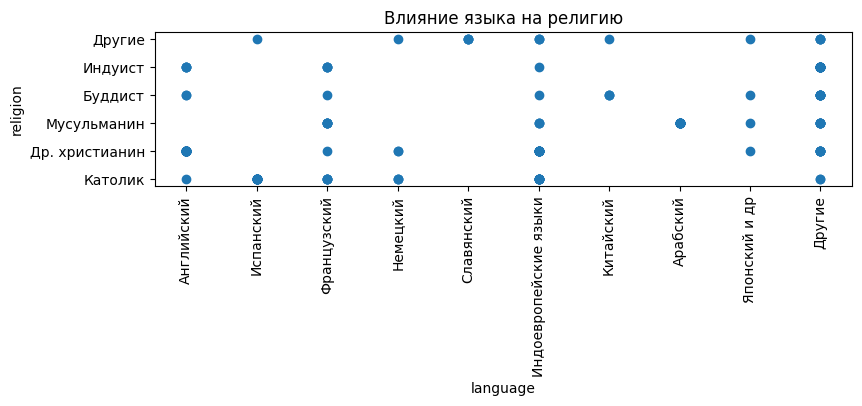

In [91]:
# влияние языка на религию
languages = ['Английский', 'Испанский', 'Французский', 'Немецкий', 'Славянский', 'Индоевропейские языки', 'Китайский', 'Арабский', 'Японский и др', 'Другие']
religions = ['Католик', 'Др. христианин', 'Мусульманин', 'Буддист', 'Индуист', 'Другие']

plt.figure(figsize=(9,2))
plt.title('Влияние языка на религию')
plt.xlabel('language')
plt.ylabel('religion')
plt.xticks(list(range(1, len(languages)+1)), languages, rotation=90)
plt.yticks(list(range(0, len(religions))), religions)

plt.scatter(data['language'], data['religion'])
plt.show()

с) Попробуем изучить флаги

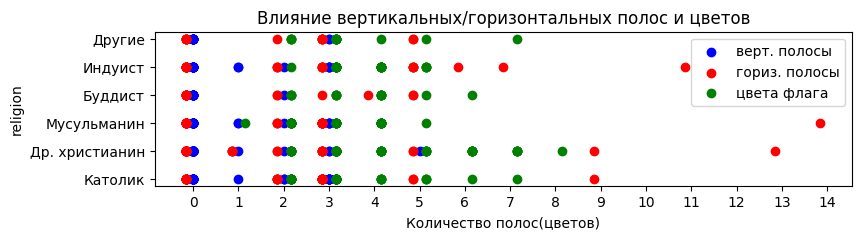

In [81]:
# количество полос и цветов
plt.figure(figsize=(9,2))
plt.title('Влияние вертикальных/горизонтальных полос и цветов')
plt.xlabel('Количество полос (цветов)')
plt.ylabel('religion')
plt.xticks(list(range(0, 20)))
plt.yticks(list(range(0, len(religions))), religions)

plt.scatter(data['bars'], data['religion'], color='b', marker='o', label='верт. полосы')
plt.scatter(data['stripes']-0.15, data['religion'], color='r', label='гориз. полосы')
plt.scatter(data['colours']+0.15, data['religion'], color='g', label='цвета флага')
plt.legend()
plt.show()

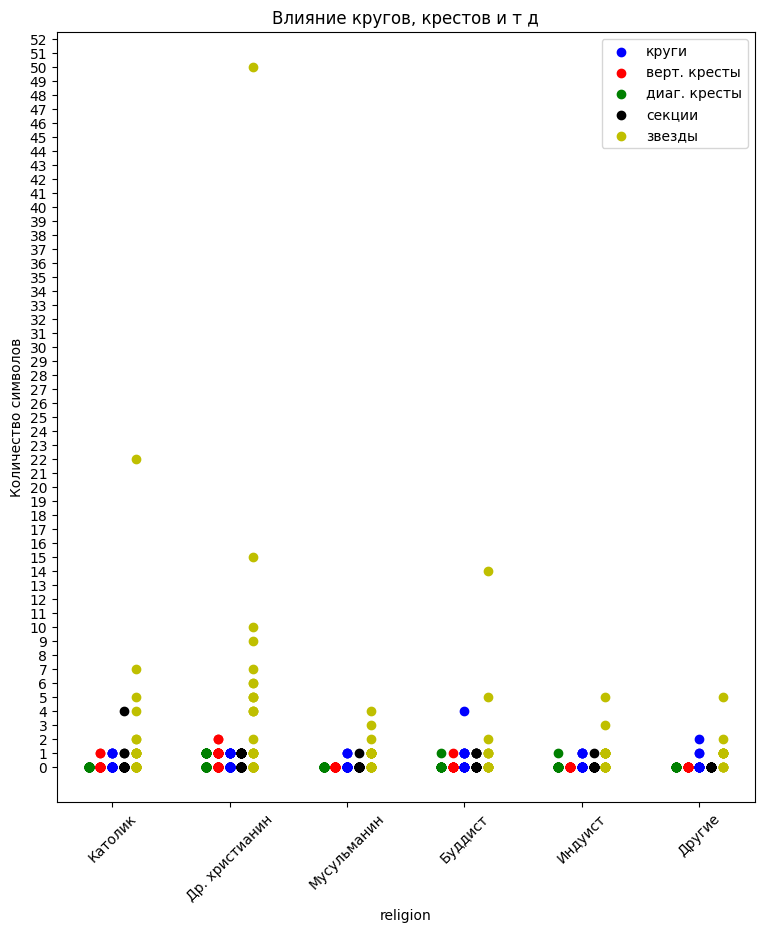

In [93]:
# количество кругов, крестов и т д
plt.figure(figsize=(9,10))
plt.title('Влияние кругов, крестов и т д')
plt.xlabel('religion')
plt.ylabel('Количество символов')
plt.xticks(list(range(0, len(religions))), religions, rotation=45)
plt.yticks(list(range(0, 60)))

plt.scatter(data['religion'], data['circles'], color='b', marker='o', label='круги')
plt.scatter(data['religion']-0.1, data['crosses'], color='r', label='верт. кресты')
plt.scatter(data['religion']-0.2, data['saltires'], color='g', label='диаг. кресты')
plt.scatter(data['religion']+0.1, data['quarters'], color='k', label='секции')
plt.scatter(data['religion']+0.2, data['sunstars'], color='y', label='звезды')
plt.legend()
plt.show()

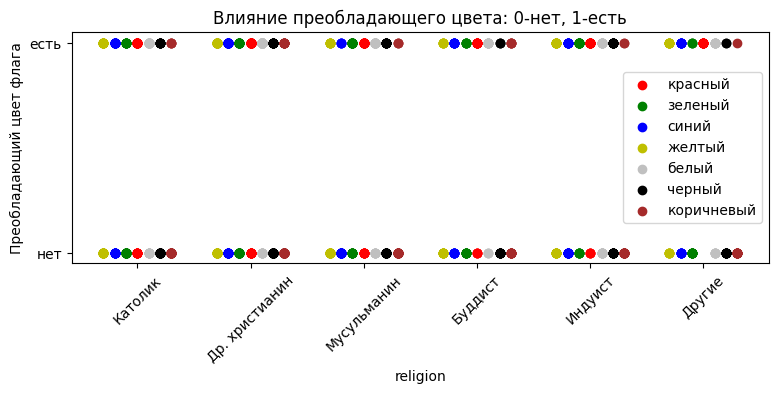

In [90]:
# преобладающие цвета флагов
plt.figure(figsize=(9,3))
plt.title('Влияние преобладающего цвета: 0-нет, 1-есть')
plt.xlabel('religion')
plt.ylabel('Преобладающий цвет флага')
plt.xticks(list(range(0, len(religions))), religions, rotation=45)
plt.yticks([0, 1], ['нет', 'есть'])

plt.scatter(data['religion'], data['red'], color='r', marker='o', label='красный')
plt.scatter(data['religion']-0.1, data['green'], color='g', marker='o', label='зеленый')
plt.scatter(data['religion']-0.2, data['blue'], color='b', marker='o', label='синий')
plt.scatter(data['religion']-0.3, data['gold'], color='y', marker='o', label='желтый')
plt.scatter(data['religion']+0.1, data['white'], color='silver', marker='o', label='белый')
plt.scatter(data['religion']+0.2, data['black'], color='k', marker='o', label='черный')
plt.scatter(data['religion']+0.3, data['orange'], color='brown', marker='o', label='коричневый')
plt.legend()
plt.show()

#3. Подготовим данные

In [94]:
y.value_counts()

,count
religion,
1,60
0,40
2,36
4,27
3,16
5,15


In [95]:
# разобрьем данные на тест и трейн
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42
                                                   )

#4. RandomForestClassifier

In [97]:
from sklearn.ensemble import RandomForestClassifier

In [98]:
# построим модель RandomForestClassifier по умолчанию
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)

In [100]:
# обучим
rfc = rfc.fit(X_train, y_train)
rfc

RandomForestClassifier(n_jobs=-1, random_state=42)

Посмотрим на важность признаков

In [25]:
# напишем функцию для визуализации
def view_features(X_train, importances):

  # построим список наших признаков
  feature_list = list(X_train)
  # соберем df из feature и importance
  feature_importance = pd.DataFrame({'feature':feature_list, 'importance':importances})

  # посмотрим
  feature_importance.plot(x='feature',
                          y='importance',
                          kind='bar'
                         )
  plt.show()

  return feature_importance.sort_values(by='importance', ascending=False)

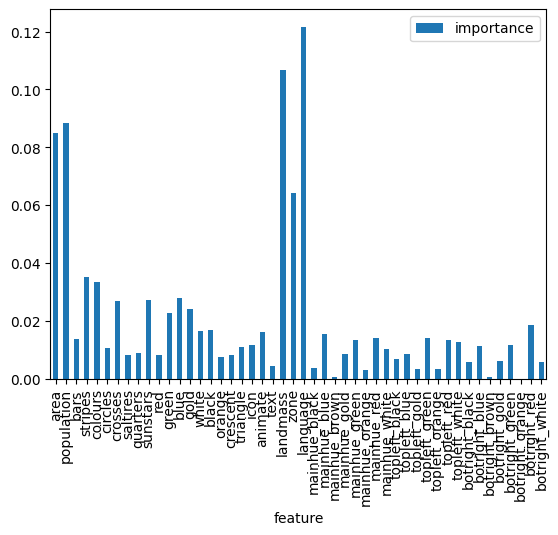

,feature,importance
24,language,0.121598
22,landmass,0.106752
1,population,0.088516
0,area,0.084872
23,zone,0.064379
3,stripes,0.035220
4,colours,0.033552
12,blue,0.028063
9,sunstars,0.027320
6,crosses,0.027066


In [26]:
# посмотрим на важность признаков
importances = rfc.feature_importances_
view_features(X_train, importances)

#Частично сбалансируем нашу выборку

Используем SMOTE

In [27]:
!pip install imbalanced-learn

In [28]:
# разобрьем данные на тест и трейн
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42
                                                   )

In [29]:
y.value_counts()

,count
religion,
1,60
0,40
2,36
4,27
3,16
5,15


In [30]:
y_train.value_counts()

,count
religion,
1,48
0,32
2,29
4,21
3,13
5,12


In [31]:
from imblearn.over_sampling import SMOTE

In [32]:
counter = {0: 32, 1: 48, 2: 29, 3: 29, 4: 29, 5: 29}

In [33]:
sm = SMOTE(
           sampling_strategy=counter, # стратегия выборки. 'auto' означает увеличение
                                      # меньшего класса до размера большинственного.
           random_state=42,           # зерно для генератора случайных чисел.
           k_neighbors=5,             # количество ближайших соседей для создания
                                      # синтетических примеров.
           n_jobs=1                   # Количество ядер для параллельной работы.
                                      # -1 означает использование всех доступных ядер.
          )

In [34]:
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [35]:
y_train_sm.value_counts()

,count
religion,
1,48
0,32
4,29
2,29
5,29
3,29


#RandomForestClassifier с учетом частично сбалансированной выборки

In [99]:
# построим модель RandomForestClassifier по умолчанию
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)

In [37]:
# обучим
rfc_sm = rfc.fit(X_train_sm, y_train_sm)
rfc_sm

RandomForestClassifier(n_jobs=-1, random_state=42)

In [38]:
# получим метрики
score_on_train = rfc_sm.score(X_train_sm, y_train_sm)
score_on_test = rfc_sm.score(X_test, y_test)

print(f'score_on_train={score_on_train :.3f}')
print(f'score_on_test ={score_on_test :.3f}')

score_on_train=1.000
score_on_test =0.692


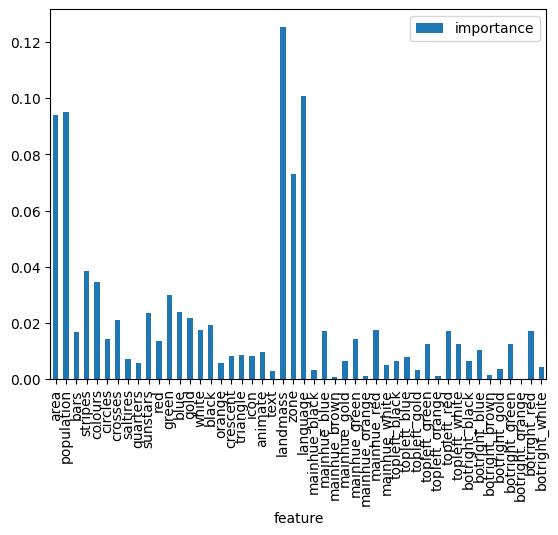

,feature,importance
22,landmass,0.125397
24,language,0.100689
1,population,0.095114
0,area,0.094197
23,zone,0.072935
3,stripes,0.038535
4,colours,0.034656
11,green,0.029881
12,blue,0.023742
9,sunstars,0.023595


In [39]:
# посмотрим на важность признаков
importances = rfc_sm.feature_importances_
view_features(X_train_sm, importances)

#Подберем лучшие параметры для RandomForestClassifier

In [40]:
from sklearn.model_selection import GridSearchCV

In [41]:
# зададим возможные параметры
param_grid = {'max_depth': [9, 12, 15],
              'max_features': [None, 'sqrt', 'log2'],
              #'max_leaf_nodes': [6, 9, 12],
              #'min_samples_leaf': [6, 9, 12],
              #'min_samples_split': [3, 6],
              'n_estimators': [25, 50, 100]
             }

In [42]:
# построим модель RandomForestClassifier
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)

In [43]:
# построим GridSearchCV модель
rfc_grid = GridSearchCV(rfc, param_grid=param_grid, cv=5, verbose=True, n_jobs=-1)

In [44]:
# обучим
rfc_grid.fit(X_train_sm, y_train_sm)
rfc_grid

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [9, 12, 15],
                         'max_features': [None, 'sqrt', 'log2'],
                         'n_estimators': [25, 50, 100]},
             verbose=True)

In [45]:
# получим наши лучшие параметры
best_params = rfc_grid.best_params_
best_params

{'max_depth': 9, 'max_features': None, 'n_estimators': 50}

In [46]:
# получим и обучим нашу лучшую модель
rfc_sm_best = rfc_grid.best_estimator_
rfc_sm_best.fit(X_train_sm, y_train_sm)
rfc_sm_best

RandomForestClassifier(max_depth=9, max_features=None, n_estimators=50,
                       n_jobs=-1, random_state=42)

In [47]:
# получим метрики
score_on_train = rfc_sm_best.score(X_train_sm, y_train_sm)
score_on_test = rfc_sm_best.score(X_test, y_test)

print(f'score_on_train={score_on_train :.3f}')
print(f'score_on_test ={score_on_test :.3f}')

score_on_train=1.000
score_on_test =0.744


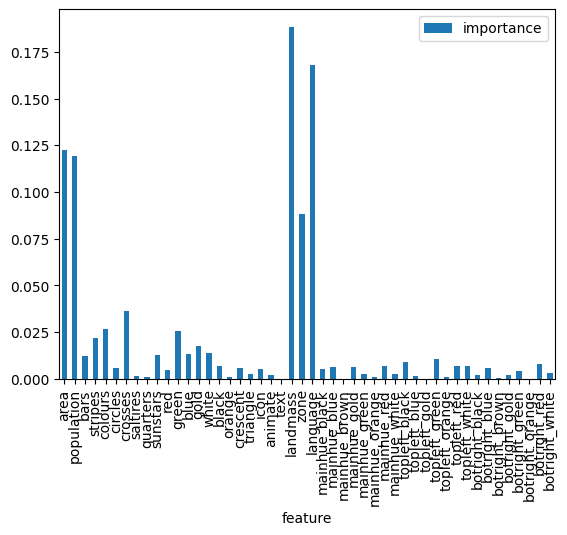

,feature,importance
22,landmass,0.188268
24,language,0.167731
0,area,0.122694
1,population,0.119519
23,zone,0.088198
6,crosses,0.036595
4,colours,0.026528
11,green,0.025850
3,stripes,0.021892
13,gold,0.017745


In [48]:
# посмотрим на важность признаков
importances = rfc_sm_best.feature_importances_
view_features(X_train_sm, importances)

#Определение избыточных признаков

Добавим рандомный признак

In [49]:
# рандомный признак random_feauture
X_train_sm_rn = X_train_sm.copy()
X_train_sm_rn['random_feauture'] = np.random.random(X_train_sm.shape[0])
X_train_sm_rn.head(2)

,area,population,bars,stripes,colours,circles,crosses,saltires,quarters,sunstars,...,topleft_white,botright_black,botright_blue,botright_brown,botright_gold,botright_green,botright_orange,botright_red,botright_white,random_feauture
0,9363,231,0,13,3,0,0,0,1,50,...,False,False,False,False,False,False,False,True,False,0.938985
1,28,0,0,3,4,0,0,0,0,0,...,False,False,False,False,False,False,False,True,False,0.557967


In [50]:
X_test_sm_rn = X_test.copy()
X_test_sm_rn['random_feauture'] = np.random.random(X_test.shape[0])
X_test_sm_rn.head(2)

,area,population,bars,stripes,colours,circles,crosses,saltires,quarters,sunstars,...,topleft_white,botright_black,botright_blue,botright_brown,botright_gold,botright_green,botright_orange,botright_red,botright_white,random_feauture
171,57,2,0,5,4,0,0,0,1,1,...,False,False,False,False,False,True,False,False,False,0.844779
44,9,1,0,0,3,0,0,0,0,0,...,True,False,False,False,False,False,False,False,True,0.086901


In [51]:
# зададим возможные параметры из предидущего расчета
param_grid = {'max_depth': [9, 12, 15],
              'max_features': [None, 'sqrt', 'log2'],
              #'max_leaf_nodes': [6, 9, 12],
              #'min_samples_leaf': [6, 9, 12],
              #'min_samples_split': [3, 6],
              'n_estimators': [25, 50, 100]
             }

In [52]:
# построим модель RandomForestClassifier
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)

In [53]:
# построим GridSearchCV модель
rfc_grid = GridSearchCV(rfc, param_grid=param_grid, cv=5, verbose=True, n_jobs=-1)

In [54]:
# обучим
rfc_grid.fit(X_train_sm_rn, y_train_sm)
rfc_grid

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [9, 12, 15],
                         'max_features': [None, 'sqrt', 'log2'],
                         'n_estimators': [25, 50, 100]},
             verbose=True)

In [55]:
# получим наши лучшие параметры
best_params = rfc_grid.best_params_
best_params

{'max_depth': 9, 'max_features': None, 'n_estimators': 50}

In [56]:
# получим и обучим нашу лучшую модель
rfc_sm_rn_best = rfc_grid.best_estimator_
rfc_sm_rn_best.fit(X_train_sm_rn, y_train_sm)
rfc_sm_rn_best

RandomForestClassifier(max_depth=9, max_features=None, n_estimators=50,
                       n_jobs=-1, random_state=42)

In [57]:
# получим метрики
score_on_train = rfc_sm_rn_best.score(X_train_sm_rn, y_train_sm)
score_on_test = rfc_sm_rn_best.score(X_test_sm_rn, y_test)

print(f'score_on_train={score_on_train :.3f}')
print(f'score_on_test ={score_on_test :.3f}')

score_on_train=1.000
score_on_test =0.615


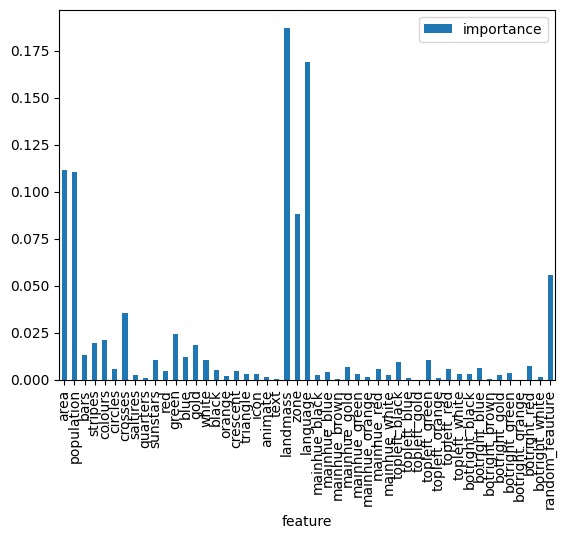

In [58]:
# посмотрим на важность признаков
importances = rfc_sm_rn_best.feature_importances_
feature_importance = view_features(X_train_sm_rn, importances)

In [59]:
# получает наши самые важные признаки
feature_importance.head(7)

,feature,importance
22,landmass,0.187395
24,language,0.169214
0,area,0.111332
1,population,0.110724
23,zone,0.087937
48,random_feauture,0.055670
6,crosses,0.035216


#RandomForestClassifier с учетом самых важных признаков

In [60]:
# собираем наши важные признаки
cols = ['landmass', 'language', 'area', 'population', 'zone', 'crosses']

In [61]:
# зададим возможные параметры
param_grid = {'max_depth': [6],
              'max_features': [None, 'sqrt', 'log2'],
              'max_leaf_nodes': [18],
              'min_samples_leaf': [3],
              'min_samples_split': [3],
              'n_estimators': [10, 25, 50, 100]
             }

In [62]:
# построим модель RandomForestClassifier
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)

In [63]:
# построим GridSearchCV модель
rfc_grid = GridSearchCV(rfc, param_grid=param_grid, cv=5, verbose=True, n_jobs=-1)

In [64]:
# обучим
rfc_grid.fit(X_train_sm[cols], y_train_sm)
rfc_grid

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [6],
                         'max_features': [None, 'sqrt', 'log2'],
                         'max_leaf_nodes': [18], 'min_samples_leaf': [3],
                         'min_samples_split': [3],
                         'n_estimators': [10, 25, 50, 100]},
             verbose=True)

In [65]:
# получим наши лучшие параметры
best_params = rfc_grid.best_params_
best_params

{'max_depth': 6,
 'max_features': 'sqrt',
 'max_leaf_nodes': 18,
 'min_samples_leaf': 3,
 'min_samples_split': 3,
 'n_estimators': 25}

In [66]:
# получим и обучим нашу лучшую модель на меньшем числе признаков
rfc_sm_min_best = rfc_grid.best_estimator_
rfc_sm_min_best.fit(X_train_sm[cols], y_train_sm)
rfc_sm_min_best

RandomForestClassifier(max_depth=6, max_leaf_nodes=18, min_samples_leaf=3,
                       min_samples_split=3, n_estimators=25, n_jobs=-1,
                       random_state=42)

In [67]:
# получим метрики
score_on_train = rfc_sm_min_best.score(X_train_sm[cols], y_train_sm)
score_on_test = rfc_sm_min_best.score(X_test[cols], y_test)

print(f'score_on_train={score_on_train :.3f}')
print(f'score_on_test ={score_on_test :.3f}')

score_on_train=0.837
score_on_test =0.769


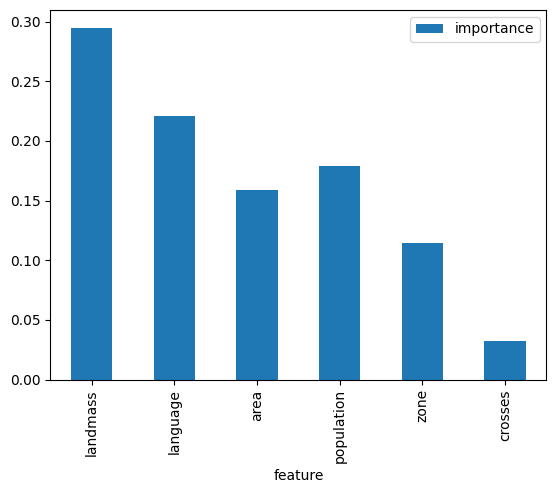

,feature,importance
0,landmass,0.295027
1,language,0.220515
3,population,0.179428
2,area,0.158513
4,zone,0.114545
5,crosses,0.031971


In [68]:
# посмотрим на важность признаков
importances = rfc_sm_min_best.feature_importances_
view_features(X_train_sm[cols], importances)

#Полная балансировка данных

In [69]:
y_train_sm.value_counts()

,count
religion,
1,48
0,32
4,29
2,29
5,29
3,29


In [70]:
counter_2 = {0: 48, 1: 48, 2: 48, 3: 48, 4: 48, 5: 48}

In [71]:
# попробуем включить большее количество соседей
sm_2 = SMOTE(
             sampling_strategy=counter_2, # стратегия выборки. 'auto' означает увеличение
                                          # меньшего класса до размера большинственного.
             random_state=42,             # зерно для генератора случайных чисел.
             k_neighbors=5,               # количество ближайших соседей для создания
                                          # синтетических примеров.
             n_jobs=1                     # Количество ядер для параллельной работы.
                                          # -1 означает использование всех доступных ядер.
            )

Создадим новую выборку на основе предидущей

In [72]:
X_train_sm_2, y_train_sm_2 = sm_2.fit_resample(X_train_sm, y_train_sm)

/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [73]:
y_train_sm_2.value_counts()

,count
religion,
1,48
4,48
2,48
0,48
5,48
3,48


#RandomForestClassifier с учетом самых важных признаков и полной балансировки признаков

In [74]:
# собираем наши важные признаки
cols = ['landmass', 'language', 'area', 'population', 'zone', 'crosses']

In [75]:
# зададим возможные параметры
param_grid = {'max_depth': [9, 12],
              'max_features': [None, 'sqrt', 'log2'],
              #'max_leaf_nodes': [21, 25, 27, 30],
              'min_samples_leaf': [4],
              'min_samples_split': [2],
              'n_estimators': [10, 25, 50, 100]
             }

In [76]:
# построим модель RandomForestClassifier
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)

In [77]:
# построим GridSearchCV модель
rfc_grid = GridSearchCV(rfc, param_grid=param_grid, cv=5, verbose=True, n_jobs=-1)

In [78]:
# обучим
rfc_grid.fit(X_train_sm_2[cols], y_train_sm_2)
rfc_grid

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [9, 12],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [4], 'min_samples_split': [2],
                         'n_estimators': [10, 25, 50, 100]},
             verbose=True)

In [79]:
# получим наши лучшие параметры
best_params = rfc_grid.best_params_
best_params

{'max_depth': 9,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 25}

In [80]:
# получим и обучим нашу лучшую модель на меньшем числе признаков
rfc_sm_2_min_best = rfc_grid.best_estimator_
rfc_sm_2_min_best.fit(X_train_sm_2[cols], y_train_sm_2)
rfc_sm_2_min_best

RandomForestClassifier(max_depth=9, min_samples_leaf=4, n_estimators=25,
                       n_jobs=-1, random_state=42)

In [81]:
# получим метрики
score_on_train = rfc_sm_2_min_best.score(X_train_sm_2[cols], y_train_sm_2)
score_on_test = rfc_sm_2_min_best.score(X_test[cols], y_test)

print(f'score_on_train={score_on_train :.3f}')
print(f'score_on_test ={score_on_test :.3f}')

score_on_train=0.878
score_on_test =0.718


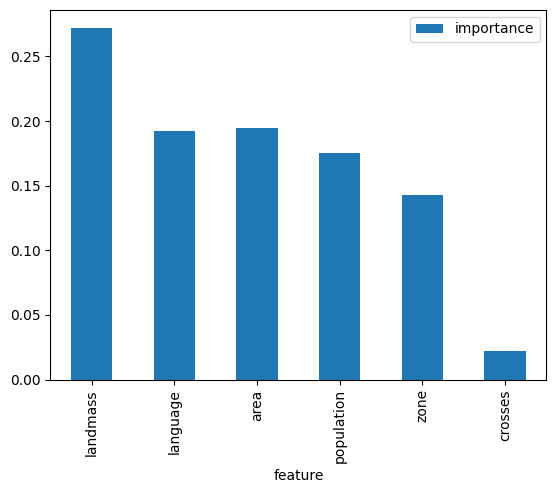

,feature,importance
0,landmass,0.272294
2,area,0.194695
1,language,0.192041
3,population,0.175559
4,zone,0.143016
5,crosses,0.022395


In [82]:
# посмотрим на важность признаков
importances = rfc_sm_2_min_best.feature_importances_
view_features(X_train_sm[cols], importances)